<div style="text-align: center;">
    <h1 style="font-size: 20px;">
        Final project for the <strong style="font-size: 26px;"> MAPD-B </strong> course<br>
        <strong style="font-size: 35px; display: block; margin-top: 20px;">4 - Batch analysis of cosmic rays using Drift Tubes detectors</strong>
    </h1>
</div>

<hr style="border: 1px solid #000;">

<div style="display: flex; justify-content: space-between; align-items: center;">
    <div style="flex: 1; text-align: center;">
        <img src="unipd_template.png" alt="Unipd template" width="400" style="margin-right: 100px; margin-left: 100px;">
    </div>
    <div>
        <img src="pod_template.png" alt="PoD template" width="250">
    </div>
</div>

<hr style="border: 1px solid #000;">

<div style="display: flex; justify-content: space-between; text-align: left; ">
    <div style="flex: 1;">
        <!-- Questo spazio può essere vuoto se non serve altro qui -->
    </div>
    <div style="flex: 1; font-size: 16px;">
        <p><strong>Degree:</strong> Physics of Data</p>
        <p><strong>Course:</strong> Management and Analysis of Physics Dataset (mod.B) </p>
        <p><strong>Year:</strong> 2023-2024</p>
        <p><strong>Teacher:</strong> prof. Jacopo Pazzini </p>
        <table style="margin: 0 auto; border-collapse: collapse; width: 80%; font-size: 15px;">
            <thead>
                <tr>
                    <th colspan="3" style="border: none; padding: 2px; text-align: center; font-weight: bold; font-size: 18px">Group 9 students</th>
                </tr>
                <tr>
                    <th style="border: none; padding: 6px;">Name</th>
                    <th style="border: none; padding: 6px;">ID</th>
                    <th style="border: none; padding: 2px;">Email</th>
                </tr>
            </thead>
            <tbody>
                <tr>
                    <td style="border: none; padding: 6px;">Ginevra Beltrame</td>
                    <td style="border: none; padding: 6px;">2130668</td>
                    <td style="border: none; padding: 2px;">ginevra.beltrame@studenti.unipd.it</td>
                </tr>
                <tr>
                    <td style="border: none; padding: 6px;">Emanuele Coradin</td>
                    <td style="border: none; padding: 6px;">2124732</td>
                    <td style="border: none; padding: 2px;">emanuele.coradin@studenti.unipd.it</td>
                </tr>
                <tr>
                    <td style="border: none; padding: 6px;">Arina Ponomareva</td>
                    <td style="border: none; padding: 6px;">2106897</td>
                    <td style="border: none; padding: 2px;">arina.ponomareva@studenti.unipd.it</td>
                </tr>
                <tr>
                    <td style="border: none; padding: 6px;">Margarita Shnaider</td>
                    <td style="border: none; padding: 6px;">2107523</td>
                    <td style="border: none; padding: 2px;">margarita.shnaider@studenti.unipd.it</td>
                </tr>
            </tbody>
        </table>
    </div>
</div>


<div style="text-align: center;">
    <h1 style="font-size: 20px;">
        <strong style="font-size: 35px; display: block; margin-top: 20px;">Part 2 - Benchmarking</strong>
    </h1>
</div>

#### Imports

In [1]:
import warnings
from sklearn.exceptions import ConvergenceWarning

import os
import seaborn as sns
import itertools
import json

import struct, time
import dask
from dask.distributed import Client
from dask.distributed import SSHCluster
from dask.distributed import LocalCluster # local cluster setup (temporary)
from dask.distributed import wait

import pandas as pd
import numpy as np
import itertools

from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import dask.dataframe as dd 
import dask.array as da
from dask.delayed import delayed
import dask.bag as db

import graphviz

import matplotlib.pyplot as plt
import matplotlib.patches as patches

dask.config.set({'dataframe.query-planning':True}) # activates an SQL-based efficient optimization of the queries in dataframes

#### Global variables

In [2]:
# Useful global variables

MAX_HIT_ORB  = 20
MIN_HIT_ORB = 6
MIN_HITS_PER_CHAMBER = 3

hreg = HuberRegressor(max_iter=30, epsilon=1.05, tol=1e-4)
CELL_WIDTH  = 42
CELL_HEIGHT = 13

n_partitions = 48

time_offset_by_chamber = {
    0: 95.0 - 1.1, # Ch 0
    1: 95.0 + 6.4, # Ch 1
    2: 95.0 + 0.5, # Ch 2
    3: 95.0 - 2.6, # Ch 3
}

start = time.time()

V_DRIFT = 53.8e-3 # µm/ns = 10^-3 mm/ns

#### Dataframe structure setup

In [3]:
fpga_column = np.array([np.zeros(128), np.ones(128)], dtype=np.int32).flatten()
tdc_column = np.hstack((np.arange(0, 128), np.arange(0, 128)))
chamber_column = np.array([np.zeros(64), np.ones(64), 2*np.ones(64), 3*np.ones(64)], dtype=np.int32).flatten()
z_column = np.array([219.8*np.ones(64), 977.3*np.ones(64), 1035.6*np.ones(64), 1819.8*np.ones(64)]).flatten()

dict_bricks = {
    'FPGA' : fpga_column,
    'TDC_CHANNEL': tdc_column,
    'Chamber': chamber_column,
    'x' : np.zeros(256),
    'y' : np.zeros(256),
    'z' : z_column,
}

df_bricks = pd.DataFrame(dict_bricks)

z_list = 13*np.array([7/2, 3/2, 5/2, 1/2])
indices = df_bricks['TDC_CHANNEL'] % 4
z_addition = indices.map(lambda idx: z_list[idx])

df_bricks['z'] = df_bricks['z'] + z_addition
df_bricks.loc[df_bricks['Chamber'].isin([0, 2, 3]), 'x'] = df_bricks['x'] + 21 * ((df_bricks['TDC_CHANNEL']%64) // 2) + 21
df_bricks.loc[df_bricks['Chamber'].isin([1]), 'y'] = df_bricks['y'] + 21 * ((df_bricks['TDC_CHANNEL']%64) // 2)

df_bricks

,FPGA,TDC_CHANNEL,Chamber,x,y,z
0,0,0,0,21.0,0.0,265.3
1,0,1,0,21.0,0.0,239.3
2,0,2,0,42.0,0.0,252.3
3,0,3,0,42.0,0.0,226.3
4,0,4,0,63.0,0.0,265.3
...,...,...,...,...,...,...
251,1,123,3,630.0,0.0,1826.3
252,1,124,3,651.0,0.0,1865.3
253,1,125,3,651.0,0.0,1839.3
254,1,126,3,672.0,0.0,1852.3


#### Processing functions definition

In [4]:
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
def read_file(filename):
    client_kwargs = {
        'endpoint_url': 'https://cloud-areapd.pd.infn.it:5210',
        'verify': False
    }
    
    # Read bytes from the specified S3 bucket with the given credentials and client configurations
    sample, blocks = dask.bytes.read_bytes(
        filename,
        key='f74a337e5aeb4b388d0284044a87aa38',
        secret='e8b5fac442dc426089f9843bcc78556a',
        client_kwargs=client_kwargs
    )
    df_chuncks = [convert_bytes(block[0]) for block in blocks]
    df = dd.from_delayed(df_chuncks)
    return df

#___________________________________________________________________________________________________________________________________
@dask.delayed
def convert_bytes(byte_file):
    word_size = 8
    head_number = 2

    # Convert byte file to a numpy array of integers
    # obs: 8 byte words can be stored into int64
    byte_array = np.frombuffer(byte_file, dtype=np.uint64)
    
    # Extract fields
    head = (byte_array >> 61) & 0x7
    fpga = (byte_array >> 58) & 0x7
    tdc_chan = (byte_array >> 49) & 0x1FF
    orb_cnt = (byte_array >> 17) & 0xFFFFFFFF
    bx = (byte_array >> 5) & 0xFFF
    tdc_meas = (byte_array >> 0) & 0x1F

    mask = (head == head_number)

    data = {
        'FPGA': fpga[mask],
        'TDC_CHANNEL': tdc_chan[mask],
        'ORB_CNT': orb_cnt[mask],
        'BX': bx[mask],
        'TDC_MEAS': tdc_meas[mask]
    }
    
    return pd.DataFrame(data)

#___________________________________________________________________________________________________________________________________
def assign_chamber(row):
    if row['FPGA'] == 0:
        if 0 <= row['TDC_CHANNEL'] <= 63:
            return 0
        elif 64 <= row['TDC_CHANNEL'] <= 127:
            return 1
    elif row['FPGA'] == 1:
        if 0 <= row['TDC_CHANNEL'] <= 63:
            return 2
        elif 64 <= row['TDC_CHANNEL'] <= 128:
            return 3
    return -1

#___________________________________________________________________________________________________________________________________
def filter_groups_part1(df):
    # Filter with scintillator's information
    scintillator_df = df[(df.FPGA == 1) & (df.TDC_CHANNEL == 128)].drop_duplicates(subset='ORB_CNT', keep='first')
    scintillator_df['t0'] = 25 * (scintillator_df['BX'] + scintillator_df['TDC_MEAS'] / 30)
    scintillator_df = scintillator_df[['ORB_CNT', 't0']]
    
    # Remove scintillator info from the main DataFrame
    df = df[df.TDC_CHANNEL < 128]

    df = df.merge(scintillator_df, on='ORB_CNT', how='inner')
    return df
    
#___________________________________________________________________________________________________________________________________
def filter_groups_part2_a(df):    
    # Assign chamber information
    df['Chamber'] = df.apply(assign_chamber, axis=1, meta=('Chamber', 'float64'))
    
    # Add further information
    df['relative_time'] = 25 * (df['BX'] + df['TDC_MEAS'] / 30)
    df = df.drop(columns=['BX', 'TDC_MEAS'])
    
    # Calculate relative time by subtracting t0
    df['relative_time'] = df['relative_time'] - df['t0']
    df = df.drop(columns=['t0'])

    # Add time offsets based on the chamber
    df['relative_time'] = df['relative_time'] + df['Chamber'].map(time_offset_by_chamber)

    # Calculate x_left and x_right positions based on the drift velocity
    df['x_left']  = - V_DRIFT*df['relative_time']
    df['x_right'] = + V_DRIFT*df['relative_time']
    df['z'] = 0

    # Drop non-physical positions
    df = df[(df.x_left.between(-CELL_WIDTH/2, 0)) & (df.x_right.between(0, CELL_WIDTH/2))]

    return df
    
#___________________________________________________________________________________________________________________________________
def filter_groups_part2_b(df):    
    # Drop events based on number of hits
   
    #Remove hits of chambers with less than MIN_HITS_PER_CHAMBER hits
    grouped = df.groupby(['ORB_CNT', 'Chamber']).filter(lambda x: len(x) >= MIN_HITS_PER_CHAMBER)
    df = df.loc[df.ORB_CNT.isin(grouped.ORB_CNT)]

    # Remove events based on total number of hits
    grouped = df.groupby('ORB_CNT').filter(lambda x: MIN_HIT_ORB <= len(x) <= MAX_HIT_ORB)
    df = df.loc[df.ORB_CNT.isin(grouped.ORB_CNT)]

    # Create a mask for Chamber 1
    mask_chamber_1 = (df['Chamber'] == 1)
    
    # For Chambers other than 1, adjust x_left and x_right positions
    df.loc[~mask_chamber_1, 'x_left']  = df.loc[~mask_chamber_1, 'x_left']  + df_bricks.loc[(df.loc[~mask_chamber_1, 'Chamber']//2)*128 + df.loc[~mask_chamber_1, 'TDC_CHANNEL'], 'x'].values
    df.loc[~mask_chamber_1, 'x_right'] = df.loc[~mask_chamber_1, 'x_right'] + df_bricks.loc[(df.loc[~mask_chamber_1, 'Chamber']//2)*128 + df.loc[~mask_chamber_1, 'TDC_CHANNEL'], 'x'].values
    
    # For Chamber 1, adjust x_left and x_right positions
    df.loc[mask_chamber_1, 'x_left']  = df.loc[mask_chamber_1, 'x_left']  + df_bricks.loc[(df.loc[mask_chamber_1, 'Chamber']//2)*128 + df.loc[mask_chamber_1, 'TDC_CHANNEL'], 'y'].values
    df.loc[mask_chamber_1, 'x_right'] = df.loc[mask_chamber_1, 'x_right'] + df_bricks.loc[(df.loc[mask_chamber_1, 'Chamber']//2)*128 + df.loc[mask_chamber_1, 'TDC_CHANNEL'], 'y'].values
    
    # Adjust z positions based on the bricks information
    df['z'] = df['z'] + df_bricks.loc[(df['Chamber']//2)*128 + df['TDC_CHANNEL'], 'z'].values

    return df

#___________________________________________________________________________________________________________________________________
def fit_tracks_vectorized(group):
    
    x_left = group['x_left'].values
    x_right = group['x_right'].values
    z = group['z'].values
    chamber = group['Chamber'].values[0]
    orb_cnt = group['ORB_CNT'].values[0]

    # Group the data by 'z' to ensure we are considering all combinations of points with the same z
    grouped_by_z = group.groupby('z')

    # List to store all combinations of x-values for different z values
    x_combinations = []
    list_stacks = []

    # Loop through each unique z value and get combinations of x_left and x_right
    for z_value, sub_group in grouped_by_z:
        x_left_sub = sub_group['x_left'].values
        x_right_sub = sub_group['x_right'].values

        # Stack left and right x-values for this z
        stack = np.column_stack((x_left_sub, x_right_sub)).flatten()
        list_stacks.append(stack)

    # Use numpy.meshgrid to create a multi-dimensional grid
    meshgrid_result = np.meshgrid(*list_stacks, indexing='ij')

    # Reshape and flatten the resulting arrays into a list of combinations
    x_combinations = np.array([grid.ravel() for grid in meshgrid_result]).T
    x_combinations_all = np.vstack(x_combinations)
    z_rows = np.sort(np.unique(group['z']))

    # Matrix for least squares: z-values and a column of ones for the intercept term
    A = np.vstack((z_rows, np.ones(len(z_rows)))).T

    # Perform least-squares fit on all combinations at once
    coeffs, residuals, _, _ = np.linalg.lstsq(A, x_combinations_all.T, rcond=None)

    # Compute chi-squared/ndof for all combinations
    chi_squared_ndof = residuals / (len(z_rows) - 2)  # Adjust degrees of freedom
    #print(np.shape(chi_squared_ndof))
    
    if chi_squared_ndof.size == 0:
        #print(f"Empty chi_squared_ndof for Chamber {chamber}, ORB_CNT {orb_cnt}")
        return None

    # Find the combination with the least chi-squared/ndof
    best_fit_idx = np.argmin(chi_squared_ndof)
    best_x = x_combinations_all[best_fit_idx]

    # Extract the best coefficients and intercept for the best fit
    reg_coef = coeffs[0][best_fit_idx]
    reg_intercept = coeffs[1][best_fit_idx]

    # Return a DataFrame with the fit results
    new_row = pd.DataFrame({
        'Chamber_': [chamber],
        'ORB_CNT_': [orb_cnt],
        'x_values': [best_x],
        'z_values': [z_rows],
        'Reg_Coefficient': [reg_coef],
        'Reg_Intercept': [reg_intercept],
        'Chi_Squared_NDOF': [chi_squared_ndof[best_fit_idx]]
    })

    return new_row
     
#___________________________________________________________________________________________________________________________________

def fit_global_tracks(group):
    orb_cnt = group['ORB_CNT'].values[0]
    group = group[group['Chamber'].isin([0, 2, 3])]
    
    if group.empty or len(group) < 2:  # Need at least 2 points for a fit
        new_row =  pd.DataFrame({
            'ORB_CNT_': [orb_cnt],
            'Reg_Coefficient': [np.nan],
            'Reg_Intercept':   [np.nan],
            'Chi_Squared_NDOF': [np.nan]
        })
        return new_row
        
    x  = np.concatenate(group['x_values'].values)
    z  = np.concatenate(group['z_values'].values).T
    
    try:
        with warnings.catch_warnings(record=True) as w:
            warnings.simplefilter("always", ConvergenceWarning)
            
            A = np.vstack((z, np.ones(len(z)))).T

            coeffs, residual, _, _ = np.linalg.lstsq(A, x.T, rcond=None)
            global_slope = coeffs[0]
            global_intercept = coeffs[1]
            
            chi_squared_ndof = residual / (len(z) - 2)
            
            if chi_squared_ndof.size == 0:
                #print(f"Empty chi_squared_ndof for Chamber {chamber}, ORB_CNT {orb_cnt}")
                return None
    
            new_row = pd.DataFrame({
                'ORB_CNT_': [orb_cnt],
                'Reg_Coefficient': [global_slope],
                'Reg_Intercept': [global_intercept],
                'Chi_Squared_NDOF': [chi_squared_ndof[0]]
            })
    
            # Check if any ConvergenceWarnings were raised
            if any(issubclass(warning.category, ConvergenceWarning) for warning in w):
                raise RuntimeError("Convergence warning captured: Increase the number of iterations (max_iter) or scale the data as shown in: https://scikit-learn.org/stable/modules/preprocessing.html")
    
    except (ValueError, RuntimeError) as e:
        #print(f"Error fitting orbit in chamber: {e}")
        new_row = pd.DataFrame({
            'ORB_CNT_': [orb_cnt],
            'Reg_Coefficient': [np.nan],
            'Reg_Intercept': [np.nan],
            'Chi_Squared_NDOF': [np.nan]
        })
    return new_row


#### Plotting functions definitions

In [58]:
def load_timings_for_partitions(partition, time_field='wall', subfolder='timings'):
    timings_data = []
    
    # Loop through all files in the current directory
    for filename in os.listdir(subfolder):
        # Only process JSON files matching the given partition
        if filename.endswith(".json") and f"p{partition}" in filename:
            with open(subfolder+'/'+filename, 'r') as f:
                data = json.load(f)
                # Extract the number of workers and threads from the filename
                workers = int(filename.split("_")[1][1:])  # Extract number after "w"
                threads = int(filename.split("_")[2][1:])  # Extract number after "t"
                
                # Store the timing data along with workers and threads
                timings_data.append((workers, threads, data[time_field]))  # 'wall' contains total execution time
                
    return timings_data

def plot_timings_heatmap(partition, time_field='wall'):
    # Load the timing data for the specified partition
    timings_data = load_timings_for_partitions(partition, time_field)
    
    # Sort data by the number of workers and threads for better visualization
    timings_data = sorted(timings_data, key=lambda x: (x[0], x[1]))

    # Create a DataFrame for the heatmap
    df = pd.DataFrame(timings_data, columns=['Workers', 'Threads', 'Time'])
    
    # Pivot the DataFrame to get a matrix format suitable for heatmap
    heatmap_data = df.pivot(index="Workers", columns="Threads", values="Time")

    # Create the heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis', cbar_kws={'label': 'Execution Time (seconds)'})
    
    # Label the plot
    plt.title(f"Execution Times Heatmap for {partition} Partitions")
    plt.xlabel("Number of Threads")
    plt.ylabel("Number of Workers")
    
    plt.show()

def plot_timings_heatmap_for_partitions(partition_list, time_field='wall'):
    # Create subplots: one subplot per partition
    n_partitions = len(partition_list)

    # Create a grid of subplots
    fig, axes = plt.subplots(2, 3, figsize=(16, 9), constrained_layout=True)

    # Load all timing data to find global min and max for colorbar
    all_timings = []
    for partition in partition_list:
        timings_data = load_timings_for_partitions(partition, time_field)
        all_timings.extend([t[2] for t in timings_data])  # Extract the 'Time' field

    global_min = min(all_timings)
    global_max = max(all_timings)
    
    # Loop through each partition and create a heatmap for it
    for idx, partition in enumerate(partition_list):
        # Load the timing data for the specified partition
        timings_data = load_timings_for_partitions(partition, time_field)
        
        # Sort data by the number of workers and threads for better visualization
        timings_data = sorted(timings_data, key=lambda x: (x[0], x[1]))
    
        # Create a DataFrame for the heatmap
        df = pd.DataFrame(timings_data, columns=['Workers', 'Threads', 'Time'])
        
        # Pivot the DataFrame to get a matrix format suitable for heatmap
        heatmap_data = df.pivot(index="Workers", columns="Threads", values="Time")
        
        # Create the heatmap in the corresponding subplot
        sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap='viridis', vmin=global_min, vmax=global_max, cbar_kws={'label': 'Execution Time (seconds)'}, ax=axes[idx//3, idx%3])
        
        # Set the title and labels for each subplot
        axes[idx//3, idx%3].set_title(f"{partition} Partitions")
        axes[idx//3, idx%3].set_xlabel("Threads")
        axes[idx//3, idx%3].set_ylabel("Workers")
    
    # Display the figure with all subplots
    plt.suptitle("Execution Times Heatmaps for Different Partitions", fontsize=16)
    plt.show()
    

def plot_time_chunks(partition_list):

    fig, ax = plt.subplots(1, 1, figsize=(15, 8), constrained_layout=True)
    
    color_time_fields = ['r', 'b', 'k', 'g', 'y']
    time_fields = ['wall', 'filtering', 'local_fit', 'global_tracks', 'angular_difference']
    
    for idx_t, time_field in enumerate(time_fields):
        time_field_dataset = []
        for idx, partition in enumerate(partition_list):
            time_field_dataset.append(load_timings_for_partitions(partition, time_field))
        
        # Initialize lists to store filtered data
        for partition_idx, partition_data in enumerate(time_field_dataset):
            x_labels = []
            y_values = []
            partition_pairs = []
            
            # Loop through each partition's data and filter
            for workers, threads, time in partition_data:
                if workers == 4:
                    partition_pairs.append(((threads, partition_list[partition_idx]), time))
            
            # Sort the data by threads
            partition_pairs.sort(key=lambda x: x[0][0])  # Sort by thread count
            
            # Unpack sorted pairs into x_labels and y_values
            for (threads, partition), time in partition_pairs:
                x_labels.append(f"({threads}, {partition})")
                y_values.append(time)
            
            # Plot each partition's data as a separate series of points
            label = f"Time field: {time_field}" if partition_idx == 0 else None
            plt.plot(x_labels, np.log(y_values), 'o-', label=label, c=color_time_fields[idx_t])
    
    # Label the axes
    plt.xlabel("(Threads, Partitions)", fontsize=12)
    plt.ylabel("Log Execution Time (seconds)", fontsize=12)
    plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
    plt.title("Execution Time vs (Threads, Partitions) for Workers=4", fontsize=14)
    plt.legend()
        
    # Display the plot
    plt.show()


#### Benchmarking process function definition

In [7]:
def benchmark(npartitions, n_workers, nthreads):
    # ------------------------ SETTING UP THE CLUSTER ------------------------
    # Define the SSH addresses and specify the number of workers per machine
    cluster = SSHCluster(
        ["10.67.22.142", "10.67.22.142", "10.67.22.209", "10.67.22.80"],
        worker_options={"nthreads": nthreads, "n_workers": n_workers},
        scheduler_options={"port": 8786, "dashboard_address": ":8787"},
        connect_options={
            "known_hosts": "/home/coradin/.ssh/known_hosts",
            "username": "coradin"
        },
        remote_python="/miniconda3/envs/DASK/bin/python",
        
    )
    
    # Optionally, create a Dask client to interact with the cluster
    client = Client(cluster, timeout='180s')
    client.wait_for_workers(n_workers)

    # ------------------------ START THE BENCHMARKING ------------------------
    timings = {}
    
    filename_all = 's3://project-bkp/data_0000*'
    df_all = read_file(filename_all)
    
    df_all = df_all.repartition(npartitions=n_partitions)
    df_all = df_all.map_partitions(filter_groups_part1)

    wall_start_time = time.time()
    df_all = filter_groups_part2_a(df_all)
    df_all = df_all.map_partitions(filter_groups_part2_b)
    df_all = df_all.persist()
    wait(df_all)
    timings['filtering'] = time.time() - wall_start_time 
    
    
    meta = pd.DataFrame({
        'Chamber_': pd.Series(dtype='int64'),
        'ORB_CNT_': pd.Series(dtype='uint64'),
        'x_values': pd.Series(dtype='object'),
        'z_values': pd.Series(dtype='object'),
        'Reg_Coefficient': pd.Series(dtype='float64'),
        'Reg_Intercept': pd.Series(dtype='float64'),
        'Chi_Squared_NDOF': pd.Series(dtype='float64')
    })

    df_regression_all = df_all.map_partitions(
        lambda partition: (
            partition
            .groupby(['Chamber', 'ORB_CNT'])
            .apply(fit_tracks_vectorized, include_groups=True) 
        ), 
        meta=meta).reset_index(drop=True).rename(columns={'Chamber_': 'Chamber', 'ORB_CNT_': 'ORB_CNT'})
    
    start_time = time.time()
    df_regression_all  = df_regression_all.persist()
    wait(df_regression_all)
    timings['local_fit'] = time.time() - start_time
    
    meta = pd.DataFrame({
        'ORB_CNT_': pd.Series(dtype='uint64'),
        'Reg_Coefficient': pd.Series(dtype='float64'),
        'Reg_Intercept':   pd.Series(dtype='float64'),
        'Chi_Squared_NDOF': pd.Series(dtype='float64')
    })

    global_tracks_df_all = df_regression_all.map_partitions(
    lambda partition: (
        partition
        .groupby(['ORB_CNT'])
        .apply(fit_global_tracks, include_groups=True)   
    ), 
    meta=meta).dropna().reset_index(drop=True).rename(columns={'ORB_CNT_': 'ORB_CNT'}).repartition(npartitions=1)


    start_time = time.time()
    global_tracks_df_all = global_tracks_df_all.persist()
    wait(global_tracks_df_all)
    timings['global_tracks'] = time.time() - start_time
    
    global_fit_df_rn_all = global_tracks_df_all[global_tracks_df_all['Chi_Squared_NDOF'] < .7].rename(columns={'Reg_Coefficient':'Reg_Coefficient_glo', 'Reg_Intercept':'Reg_Intercept_glo'})
    regression_results_df_ch2_rn_all = df_regression_all.rename(columns={'Chamber_':'Chamber', 'ORB_CNT_':'ORB_CNT', 'Reg_Coefficient':'Reg_Coefficient_loc', 'Reg_Intercept':'Reg_Intercept_loc'}).dropna()
    df_ang_diff_all = global_fit_df_rn_all.merge(regression_results_df_ch2_rn_all, on = ['ORB_CNT'])

    df_ang_diff_all['Angular difference'] = (np.arctan(df_ang_diff_all['Reg_Coefficient_glo']) - np.arctan(df_ang_diff_all['Reg_Coefficient_loc']))*180/np.pi

    start_time = time.time()
    res = df_ang_diff_all.compute()
    timings['angular_difference'] = time.time() - start_time
    timings['wall'] = time.time() - wall_start_time

    client.close()
    cluster.close()
    
    return timings

## Processing

In [64]:
# Define the lists of workers, threads, and partitions
n_workers      = [1, 2, 4, 8, 32]
n_threads      = [1, 2, 4, 8, 32] 
partition_list = [3, 6, 12, 48, 150, 1000] 

In [52]:
# Generate all combinations of workers, threads, and partitions
combinations = list(itertools.product(n_workers, n_threads, partition_list))

for idx, (workers, threads, partitions) in enumerate(combinations):
    # Define a filename based on the combination of parameters
    filename = f"timings/benchmark_w{workers}_t{threads}_p{partitions}.json"
    
    # Check if the file already exists
    if os.path.exists(filename):
        print(f"File {filename} already exists. Skipping computation.")
        continue  # Skip the current iteration if the file exists
    
    print(f"Running benchmark with {workers} workers, {threads} threads, and {partitions} partitions...")
    
    # Run the benchmark with the current combination of workers, threads, and partitions
    timings = benchmark(partitions, workers, threads)
    
    # Save the results to a file in JSON format
    with open(filename, 'w') as f:
        json.dump(timings, f)
    
    print(f"Saved timings to {filename}")
    
    # Sleep for 5 seconds between runs to avoid overloading the system
    time.sleep(3)

Running benchmark with 1 workers, 1 threads, and 3 partitions...


2024-09-16 13:30:38,494 - distributed.deploy.ssh - INFO - 2024-09-16 13:30:38,497 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:30:38,514 - distributed.deploy.ssh - INFO - 2024-09-16 13:30:38,517 - distributed.scheduler - INFO - State start
2024-09-16 13:30:38,515 - distributed.deploy.ssh - INFO - 2024-09-16 13:30:38,518 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s2q50kni', purging
2024-09-16 13:30:38,516 - distributed.deploy.ssh - INFO - 2024-09-16 13:30:38,518 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-y37g54ol', purging
2024-09-16 13:30:38,516 - distributed.deploy.ssh - INFO - 2024-09-16 13:30:38,518 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-nj7s0knj', purging
2024-09-16 13:30:38,516 - di

Saved timings to timings/benchmark_w1_t1_p3.json
File timings/benchmark_w1_t1_p6.json already exists. Skipping computation.
File timings/benchmark_w1_t1_p12.json already exists. Skipping computation.
File timings/benchmark_w1_t1_p48.json already exists. Skipping computation.
File timings/benchmark_w1_t1_p150.json already exists. Skipping computation.
File timings/benchmark_w1_t1_p1000.json already exists. Skipping computation.
Running benchmark with 1 workers, 2 threads, and 3 partitions...


2024-09-16 13:32:16,638 - distributed.deploy.ssh - INFO - 2024-09-16 13:32:16,640 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:32:16,657 - distributed.deploy.ssh - INFO - 2024-09-16 13:32:16,660 - distributed.scheduler - INFO - State start
2024-09-16 13:32:16,658 - distributed.deploy.ssh - INFO - 2024-09-16 13:32:16,660 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-rztr2a6t', purging
2024-09-16 13:32:16,660 - distributed.deploy.ssh - INFO - 2024-09-16 13:32:16,663 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:32:18,640 - distributed.deploy.ssh - INFO - 2024-09-16 13:32:18,643 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.142:34139'
2024-09-16 13:32:18,870 - distributed.deploy.ssh - INFO - 2024-09-16 13:32:18,872 - distributed.nanny - INFO -   

Saved timings to timings/benchmark_w1_t2_p3.json
File timings/benchmark_w1_t2_p6.json already exists. Skipping computation.
File timings/benchmark_w1_t2_p12.json already exists. Skipping computation.
File timings/benchmark_w1_t2_p48.json already exists. Skipping computation.
File timings/benchmark_w1_t2_p150.json already exists. Skipping computation.
File timings/benchmark_w1_t2_p1000.json already exists. Skipping computation.
Running benchmark with 1 workers, 4 threads, and 3 partitions...


2024-09-16 13:34:08,879 - distributed.deploy.ssh - INFO - 2024-09-16 13:34:08,881 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:34:08,899 - distributed.deploy.ssh - INFO - 2024-09-16 13:34:08,901 - distributed.scheduler - INFO - State start
2024-09-16 13:34:08,899 - distributed.deploy.ssh - INFO - 2024-09-16 13:34:08,901 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-644xc7m8', purging
2024-09-16 13:34:08,902 - distributed.deploy.ssh - INFO - 2024-09-16 13:34:08,904 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:34:10,890 - distributed.deploy.ssh - INFO - 2024-09-16 13:34:10,891 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.142:38673'
2024-09-16 13:34:10,895 - distributed.deploy.ssh - INFO - 2024-09-16 13:34:10,897 - distributed.nanny - INFO -   

Saved timings to timings/benchmark_w1_t4_p3.json
File timings/benchmark_w1_t4_p6.json already exists. Skipping computation.
File timings/benchmark_w1_t4_p12.json already exists. Skipping computation.
File timings/benchmark_w1_t4_p48.json already exists. Skipping computation.
File timings/benchmark_w1_t4_p150.json already exists. Skipping computation.
File timings/benchmark_w1_t4_p1000.json already exists. Skipping computation.
Running benchmark with 1 workers, 8 threads, and 3 partitions...


2024-09-16 13:36:22,421 - distributed.deploy.ssh - INFO - 2024-09-16 13:36:22,422 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:36:22,440 - distributed.deploy.ssh - INFO - 2024-09-16 13:36:22,442 - distributed.scheduler - INFO - State start
2024-09-16 13:36:22,441 - distributed.deploy.ssh - INFO - 2024-09-16 13:36:22,442 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-vzmtvxr1', purging
2024-09-16 13:36:22,443 - distributed.deploy.ssh - INFO - 2024-09-16 13:36:22,445 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:36:24,417 - distributed.deploy.ssh - INFO - 2024-09-16 13:36:24,418 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.142:44411'
2024-09-16 13:36:24,432 - distributed.deploy.ssh - INFO - 2024-09-16 13:36:24,433 - distributed.nanny - INFO -   

Saved timings to timings/benchmark_w1_t8_p3.json
File timings/benchmark_w1_t8_p6.json already exists. Skipping computation.
File timings/benchmark_w1_t8_p12.json already exists. Skipping computation.
File timings/benchmark_w1_t8_p48.json already exists. Skipping computation.
File timings/benchmark_w1_t8_p150.json already exists. Skipping computation.
File timings/benchmark_w1_t8_p1000.json already exists. Skipping computation.
Running benchmark with 2 workers, 1 threads, and 3 partitions...


2024-09-16 13:38:48,391 - distributed.deploy.ssh - INFO - 2024-09-16 13:38:48,392 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:38:48,411 - distributed.deploy.ssh - INFO - 2024-09-16 13:38:48,412 - distributed.scheduler - INFO - State start
2024-09-16 13:38:48,411 - distributed.deploy.ssh - INFO - 2024-09-16 13:38:48,412 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-9706ianb', purging
2024-09-16 13:38:48,414 - distributed.deploy.ssh - INFO - 2024-09-16 13:38:48,415 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:38:50,408 - distributed.deploy.ssh - INFO - 2024-09-16 13:38:50,409 - distributed.nanny - INFO -         Start Nanny at: 'tcp://10.67.22.142:38947'
2024-09-16 13:38:50,411 - distributed.deploy.ssh - INFO - 2024-09-16 13:38:50,412 - distributed.nanny - INFO -   

Saved timings to timings/benchmark_w2_t1_p3.json
File timings/benchmark_w2_t1_p6.json already exists. Skipping computation.
File timings/benchmark_w2_t1_p12.json already exists. Skipping computation.
File timings/benchmark_w2_t1_p48.json already exists. Skipping computation.
File timings/benchmark_w2_t1_p150.json already exists. Skipping computation.
File timings/benchmark_w2_t1_p1000.json already exists. Skipping computation.
Running benchmark with 2 workers, 2 threads, and 3 partitions...


2024-09-16 13:39:49,775 - distributed.deploy.ssh - INFO - 2024-09-16 13:39:49,775 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:39:49,794 - distributed.deploy.ssh - INFO - 2024-09-16 13:39:49,795 - distributed.scheduler - INFO - State start
2024-09-16 13:39:49,795 - distributed.deploy.ssh - INFO - 2024-09-16 13:39:49,796 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hzshrya5', purging
2024-09-16 13:39:49,795 - distributed.deploy.ssh - INFO - 2024-09-16 13:39:49,796 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-omyk1w2e', purging
2024-09-16 13:39:49,797 - distributed.deploy.ssh - INFO - 2024-09-16 13:39:49,798 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:39:51,782 - distributed.deploy.ssh - INFO - 2024-09-16 13:3

Saved timings to timings/benchmark_w2_t2_p3.json
File timings/benchmark_w2_t2_p6.json already exists. Skipping computation.
File timings/benchmark_w2_t2_p12.json already exists. Skipping computation.
File timings/benchmark_w2_t2_p48.json already exists. Skipping computation.
File timings/benchmark_w2_t2_p150.json already exists. Skipping computation.
File timings/benchmark_w2_t2_p1000.json already exists. Skipping computation.
Running benchmark with 2 workers, 4 threads, and 3 partitions...


2024-09-16 13:40:58,864 - distributed.deploy.ssh - INFO - 2024-09-16 13:40:58,865 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:40:58,884 - distributed.deploy.ssh - INFO - 2024-09-16 13:40:58,885 - distributed.scheduler - INFO - State start
2024-09-16 13:40:58,885 - distributed.deploy.ssh - INFO - 2024-09-16 13:40:58,885 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-1pavw8im', purging
2024-09-16 13:40:58,886 - distributed.deploy.ssh - INFO - 2024-09-16 13:40:58,886 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-z75fy6a7', purging
2024-09-16 13:40:58,887 - distributed.deploy.ssh - INFO - 2024-09-16 13:40:58,888 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:41:00,880 - distributed.deploy.ssh - INFO - 2024-09-16 13:4

Saved timings to timings/benchmark_w2_t4_p3.json
File timings/benchmark_w2_t4_p6.json already exists. Skipping computation.
File timings/benchmark_w2_t4_p12.json already exists. Skipping computation.
File timings/benchmark_w2_t4_p48.json already exists. Skipping computation.
File timings/benchmark_w2_t4_p150.json already exists. Skipping computation.
File timings/benchmark_w2_t4_p1000.json already exists. Skipping computation.
Running benchmark with 2 workers, 8 threads, and 3 partitions...


2024-09-16 13:42:24,679 - distributed.deploy.ssh - INFO - 2024-09-16 13:42:24,680 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:42:24,699 - distributed.deploy.ssh - INFO - 2024-09-16 13:42:24,700 - distributed.scheduler - INFO - State start
2024-09-16 13:42:24,700 - distributed.deploy.ssh - INFO - 2024-09-16 13:42:24,701 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-q3rbzl2w', purging
2024-09-16 13:42:24,701 - distributed.deploy.ssh - INFO - 2024-09-16 13:42:24,701 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-wvfqqkmk', purging
2024-09-16 13:42:24,703 - distributed.deploy.ssh - INFO - 2024-09-16 13:42:24,704 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:42:26,698 - distributed.deploy.ssh - INFO - 2024-09-16 13:4

Saved timings to timings/benchmark_w2_t8_p3.json
File timings/benchmark_w2_t8_p6.json already exists. Skipping computation.
File timings/benchmark_w2_t8_p12.json already exists. Skipping computation.
File timings/benchmark_w2_t8_p48.json already exists. Skipping computation.
File timings/benchmark_w2_t8_p150.json already exists. Skipping computation.
File timings/benchmark_w2_t8_p1000.json already exists. Skipping computation.
Running benchmark with 4 workers, 1 threads, and 3 partitions...


2024-09-16 13:44:17,447 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:17,447 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:44:17,466 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:17,467 - distributed.scheduler - INFO - State start
2024-09-16 13:44:17,467 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:17,468 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-yckzwrek', purging
2024-09-16 13:44:17,468 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:17,468 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-pzoc5l8p', purging
2024-09-16 13:44:17,469 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:17,470 - distributed.scheduler - INFO -   Scheduler at:   tcp://10.67.22.142:8786
2024-09-16 13:44:19,466 - distributed.deploy.ssh - INFO - 2024-09-16 13:4

Saved timings to timings/benchmark_w4_t1_p3.json
File timings/benchmark_w4_t1_p6.json already exists. Skipping computation.
File timings/benchmark_w4_t1_p12.json already exists. Skipping computation.
File timings/benchmark_w4_t1_p48.json already exists. Skipping computation.
File timings/benchmark_w4_t1_p150.json already exists. Skipping computation.
File timings/benchmark_w4_t1_p1000.json already exists. Skipping computation.
Running benchmark with 4 workers, 2 threads, and 3 partitions...


2024-09-16 13:44:59,963 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:59,963 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:44:59,983 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:59,983 - distributed.scheduler - INFO - State start
2024-09-16 13:44:59,984 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:59,984 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-81pshq_m', purging
2024-09-16 13:44:59,984 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:59,984 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hp5ztbh3', purging
2024-09-16 13:44:59,985 - distributed.deploy.ssh - INFO - 2024-09-16 13:44:59,985 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ugqc_b6z', purging
2024-09-16 13:44:59,985 - di

Saved timings to timings/benchmark_w4_t2_p3.json
File timings/benchmark_w4_t2_p6.json already exists. Skipping computation.
File timings/benchmark_w4_t2_p12.json already exists. Skipping computation.
File timings/benchmark_w4_t2_p48.json already exists. Skipping computation.
File timings/benchmark_w4_t2_p150.json already exists. Skipping computation.
File timings/benchmark_w4_t2_p1000.json already exists. Skipping computation.
Running benchmark with 4 workers, 4 threads, and 3 partitions...


2024-09-16 13:45:52,743 - distributed.deploy.ssh - INFO - 2024-09-16 13:45:52,743 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:45:52,763 - distributed.deploy.ssh - INFO - 2024-09-16 13:45:52,763 - distributed.scheduler - INFO - State start
2024-09-16 13:45:52,764 - distributed.deploy.ssh - INFO - 2024-09-16 13:45:52,764 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-4l83qqhj', purging
2024-09-16 13:45:52,764 - distributed.deploy.ssh - INFO - 2024-09-16 13:45:52,764 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-fk3sx1y0', purging
2024-09-16 13:45:52,764 - distributed.deploy.ssh - INFO - 2024-09-16 13:45:52,765 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-dc7gg0tc', purging
2024-09-16 13:45:52,765 - di

Saved timings to timings/benchmark_w4_t4_p3.json
File timings/benchmark_w4_t4_p6.json already exists. Skipping computation.
File timings/benchmark_w4_t4_p12.json already exists. Skipping computation.
File timings/benchmark_w4_t4_p48.json already exists. Skipping computation.
File timings/benchmark_w4_t4_p150.json already exists. Skipping computation.
File timings/benchmark_w4_t4_p1000.json already exists. Skipping computation.
Running benchmark with 4 workers, 8 threads, and 3 partitions...


2024-09-16 13:46:59,334 - distributed.deploy.ssh - INFO - 2024-09-16 13:46:59,335 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:46:59,355 - distributed.deploy.ssh - INFO - 2024-09-16 13:46:59,355 - distributed.scheduler - INFO - State start
2024-09-16 13:46:59,356 - distributed.deploy.ssh - INFO - 2024-09-16 13:46:59,356 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-n4poqquo', purging
2024-09-16 13:46:59,356 - distributed.deploy.ssh - INFO - 2024-09-16 13:46:59,356 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-f3u_oldh', purging
2024-09-16 13:46:59,357 - distributed.deploy.ssh - INFO - 2024-09-16 13:46:59,356 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-h30t205d', purging
2024-09-16 13:46:59,357 - di

Saved timings to timings/benchmark_w4_t8_p3.json
File timings/benchmark_w4_t8_p6.json already exists. Skipping computation.
File timings/benchmark_w4_t8_p12.json already exists. Skipping computation.
File timings/benchmark_w4_t8_p48.json already exists. Skipping computation.
File timings/benchmark_w4_t8_p150.json already exists. Skipping computation.
File timings/benchmark_w4_t8_p1000.json already exists. Skipping computation.
Running benchmark with 8 workers, 1 threads, and 3 partitions...


2024-09-16 13:48:30,198 - distributed.deploy.ssh - INFO - 2024-09-16 13:48:30,198 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:48:30,218 - distributed.deploy.ssh - INFO - 2024-09-16 13:48:30,218 - distributed.scheduler - INFO - State start
2024-09-16 13:48:30,219 - distributed.deploy.ssh - INFO - 2024-09-16 13:48:30,219 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-a_v2vijr', purging
2024-09-16 13:48:30,220 - distributed.deploy.ssh - INFO - 2024-09-16 13:48:30,219 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-s9i4yyi_', purging
2024-09-16 13:48:30,220 - distributed.deploy.ssh - INFO - 2024-09-16 13:48:30,220 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-151y0amx', purging
2024-09-16 13:48:30,221 - di

Saved timings to timings/benchmark_w8_t1_p3.json
File timings/benchmark_w8_t1_p6.json already exists. Skipping computation.
File timings/benchmark_w8_t1_p12.json already exists. Skipping computation.
File timings/benchmark_w8_t1_p48.json already exists. Skipping computation.
File timings/benchmark_w8_t1_p150.json already exists. Skipping computation.
File timings/benchmark_w8_t1_p1000.json already exists. Skipping computation.
Running benchmark with 8 workers, 2 threads, and 3 partitions...


2024-09-16 13:49:16,388 - distributed.deploy.ssh - INFO - 2024-09-16 13:49:16,388 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:49:16,408 - distributed.deploy.ssh - INFO - 2024-09-16 13:49:16,408 - distributed.scheduler - INFO - State start
2024-09-16 13:49:16,410 - distributed.deploy.ssh - INFO - 2024-09-16 13:49:16,409 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-_22iow16', purging
2024-09-16 13:49:16,410 - distributed.deploy.ssh - INFO - 2024-09-16 13:49:16,409 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-d9ebop6t', purging
2024-09-16 13:49:16,411 - distributed.deploy.ssh - INFO - 2024-09-16 13:49:16,410 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hxdpqrom', purging
2024-09-16 13:49:16,411 - di

Saved timings to timings/benchmark_w8_t2_p3.json
File timings/benchmark_w8_t2_p6.json already exists. Skipping computation.
File timings/benchmark_w8_t2_p12.json already exists. Skipping computation.
File timings/benchmark_w8_t2_p48.json already exists. Skipping computation.
File timings/benchmark_w8_t2_p150.json already exists. Skipping computation.
File timings/benchmark_w8_t2_p1000.json already exists. Skipping computation.
Running benchmark with 8 workers, 4 threads, and 3 partitions...


2024-09-16 13:50:08,402 - distributed.deploy.ssh - INFO - 2024-09-16 13:50:08,402 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:50:08,423 - distributed.deploy.ssh - INFO - 2024-09-16 13:50:08,423 - distributed.scheduler - INFO - State start
2024-09-16 13:50:08,424 - distributed.deploy.ssh - INFO - 2024-09-16 13:50:08,424 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-hphb_ltw', purging
2024-09-16 13:50:08,425 - distributed.deploy.ssh - INFO - 2024-09-16 13:50:08,424 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-6urntn6z', purging
2024-09-16 13:50:08,426 - distributed.deploy.ssh - INFO - 2024-09-16 13:50:08,424 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-vb6o8_iz', purging
2024-09-16 13:50:08,426 - di

Saved timings to timings/benchmark_w8_t4_p3.json
File timings/benchmark_w8_t4_p6.json already exists. Skipping computation.
File timings/benchmark_w8_t4_p12.json already exists. Skipping computation.
File timings/benchmark_w8_t4_p48.json already exists. Skipping computation.
File timings/benchmark_w8_t4_p150.json already exists. Skipping computation.
File timings/benchmark_w8_t4_p1000.json already exists. Skipping computation.
Running benchmark with 8 workers, 8 threads, and 3 partitions...


2024-09-16 13:51:12,349 - distributed.deploy.ssh - INFO - 2024-09-16 13:51:12,349 - distributed.http.proxy - INFO - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-09-16 13:51:12,369 - distributed.deploy.ssh - INFO - 2024-09-16 13:51:12,369 - distributed.scheduler - INFO - State start
2024-09-16 13:51:12,370 - distributed.deploy.ssh - INFO - 2024-09-16 13:51:12,370 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-z9v540sp', purging
2024-09-16 13:51:12,370 - distributed.deploy.ssh - INFO - 2024-09-16 13:51:12,370 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ufa0_j3y', purging
2024-09-16 13:51:12,371 - distributed.deploy.ssh - INFO - 2024-09-16 13:51:12,371 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-bj11om2q', purging
2024-09-16 13:51:12,371 - di

Saved timings to timings/benchmark_w8_t8_p3.json
File timings/benchmark_w8_t8_p6.json already exists. Skipping computation.
File timings/benchmark_w8_t8_p12.json already exists. Skipping computation.
File timings/benchmark_w8_t8_p48.json already exists. Skipping computation.
File timings/benchmark_w8_t8_p150.json already exists. Skipping computation.
File timings/benchmark_w8_t8_p1000.json already exists. Skipping computation.


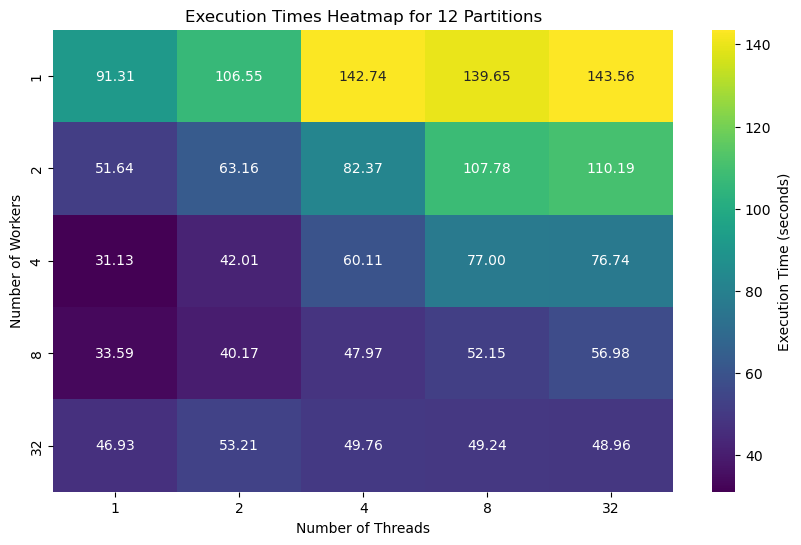

In [66]:
plot_timings_heatmap(12)

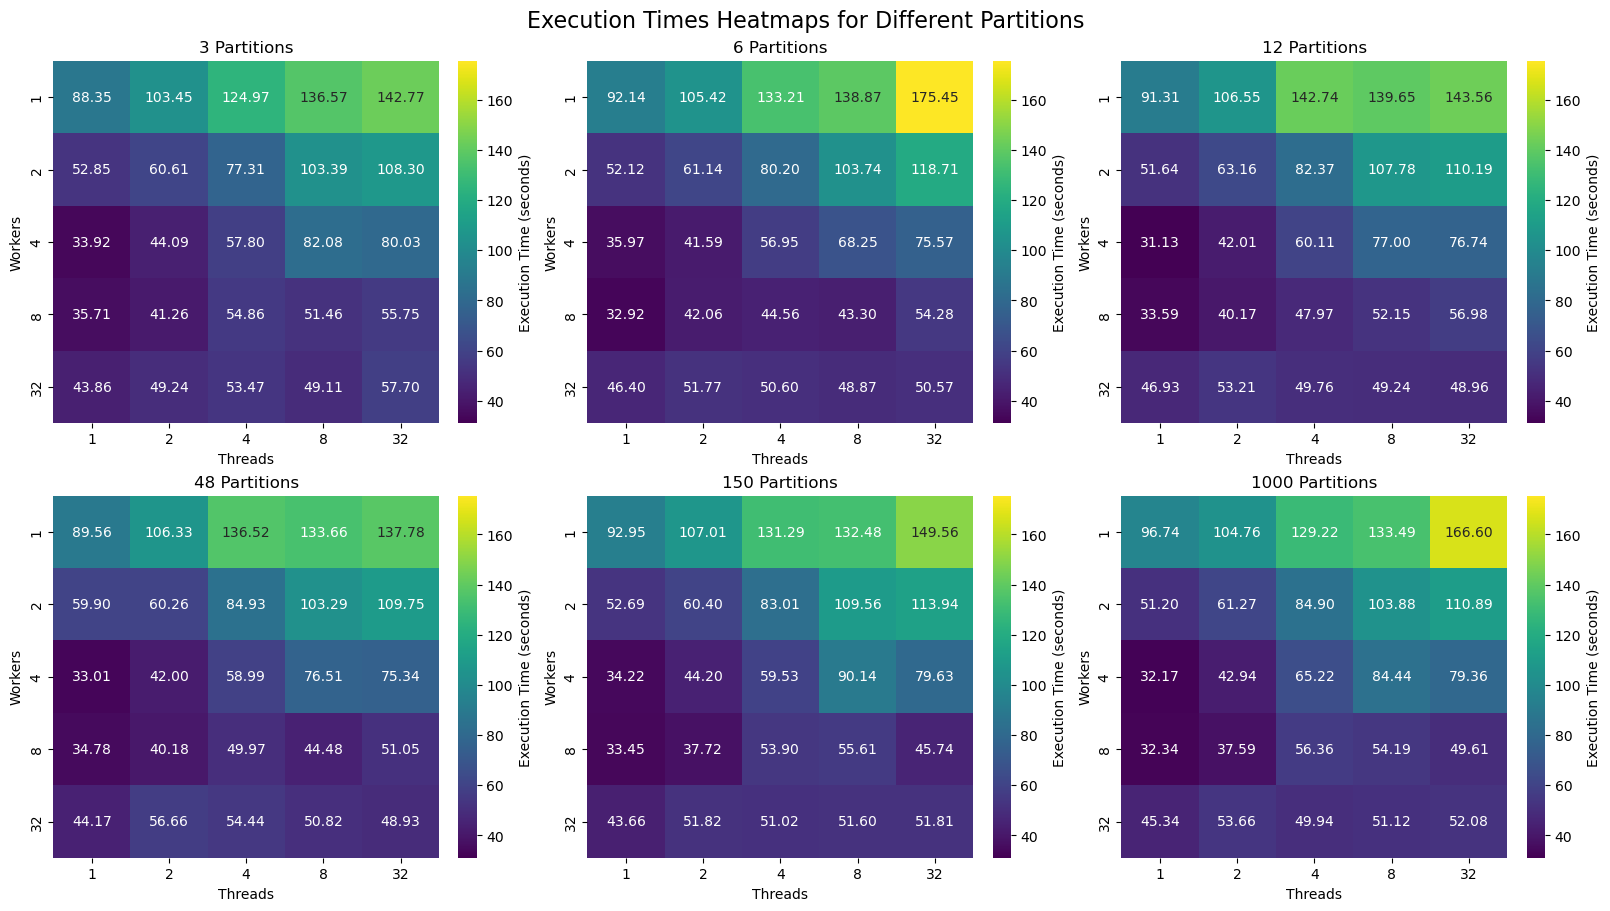

In [67]:
plot_timings_heatmap_for_partitions(partition_list, 'wall')

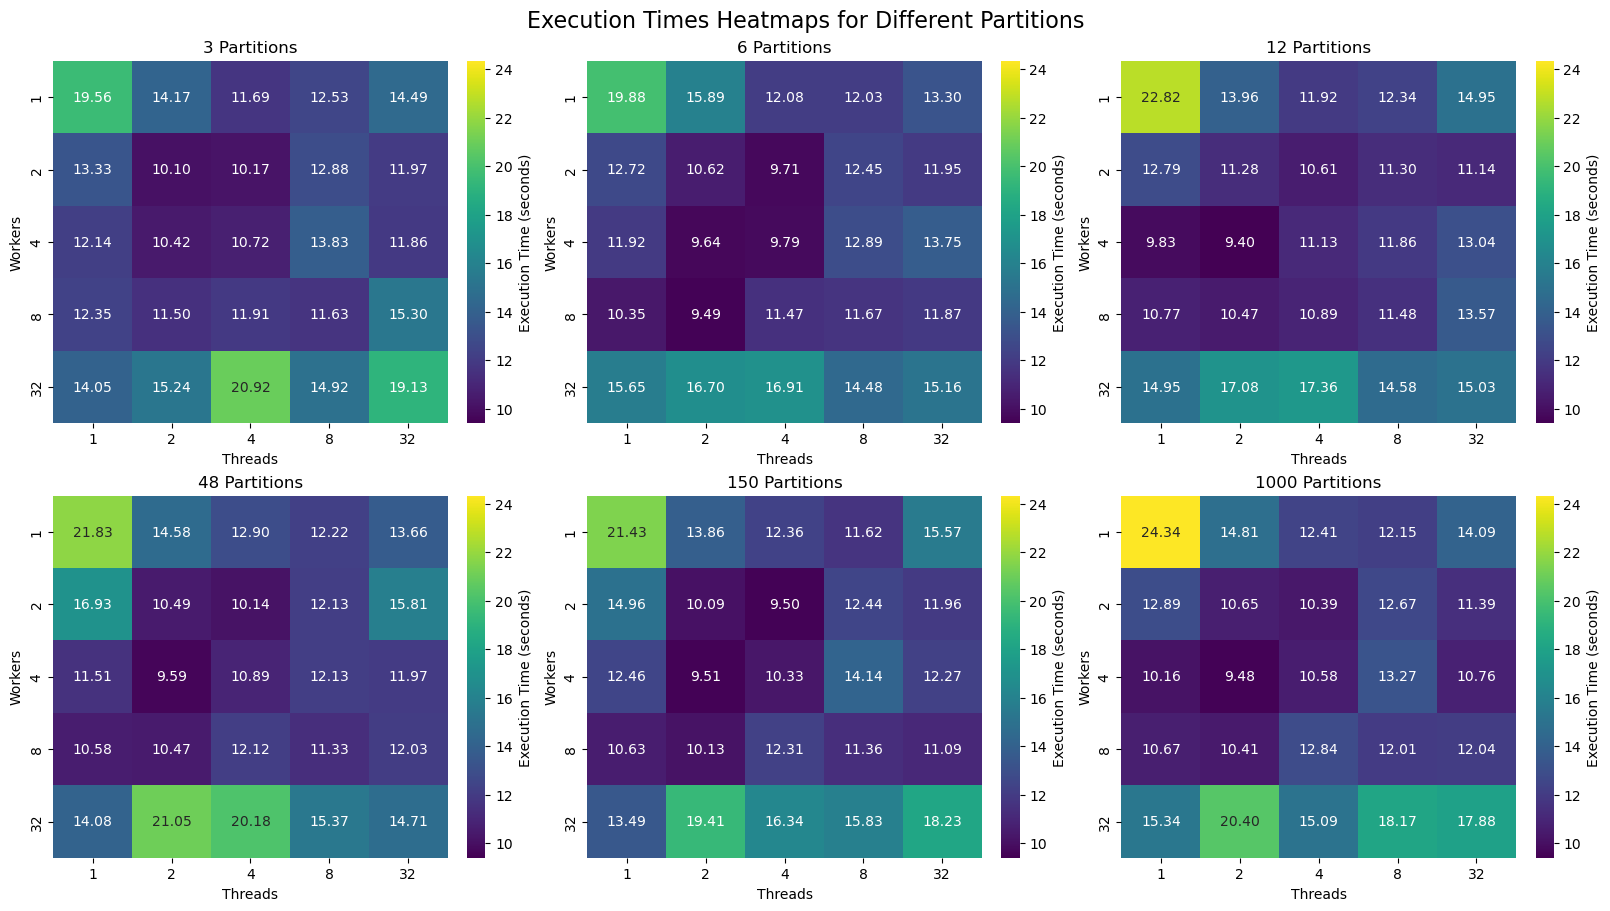

In [68]:
plot_timings_heatmap_for_partitions(partition_list, 'filtering')

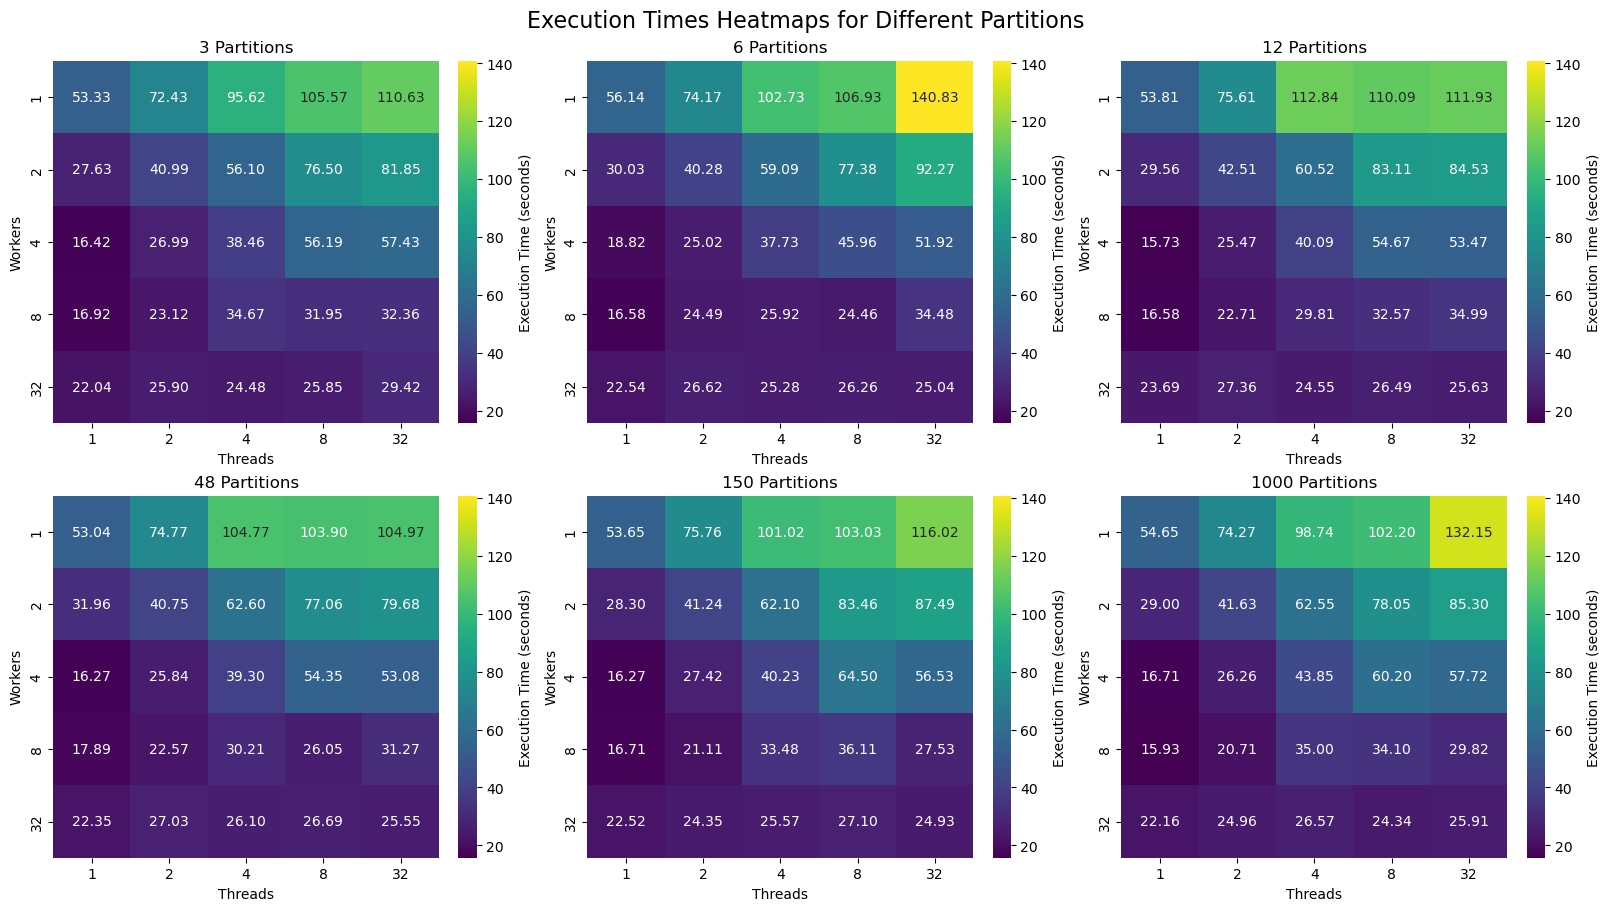

In [69]:
plot_timings_heatmap_for_partitions(partition_list, 'local_fit')

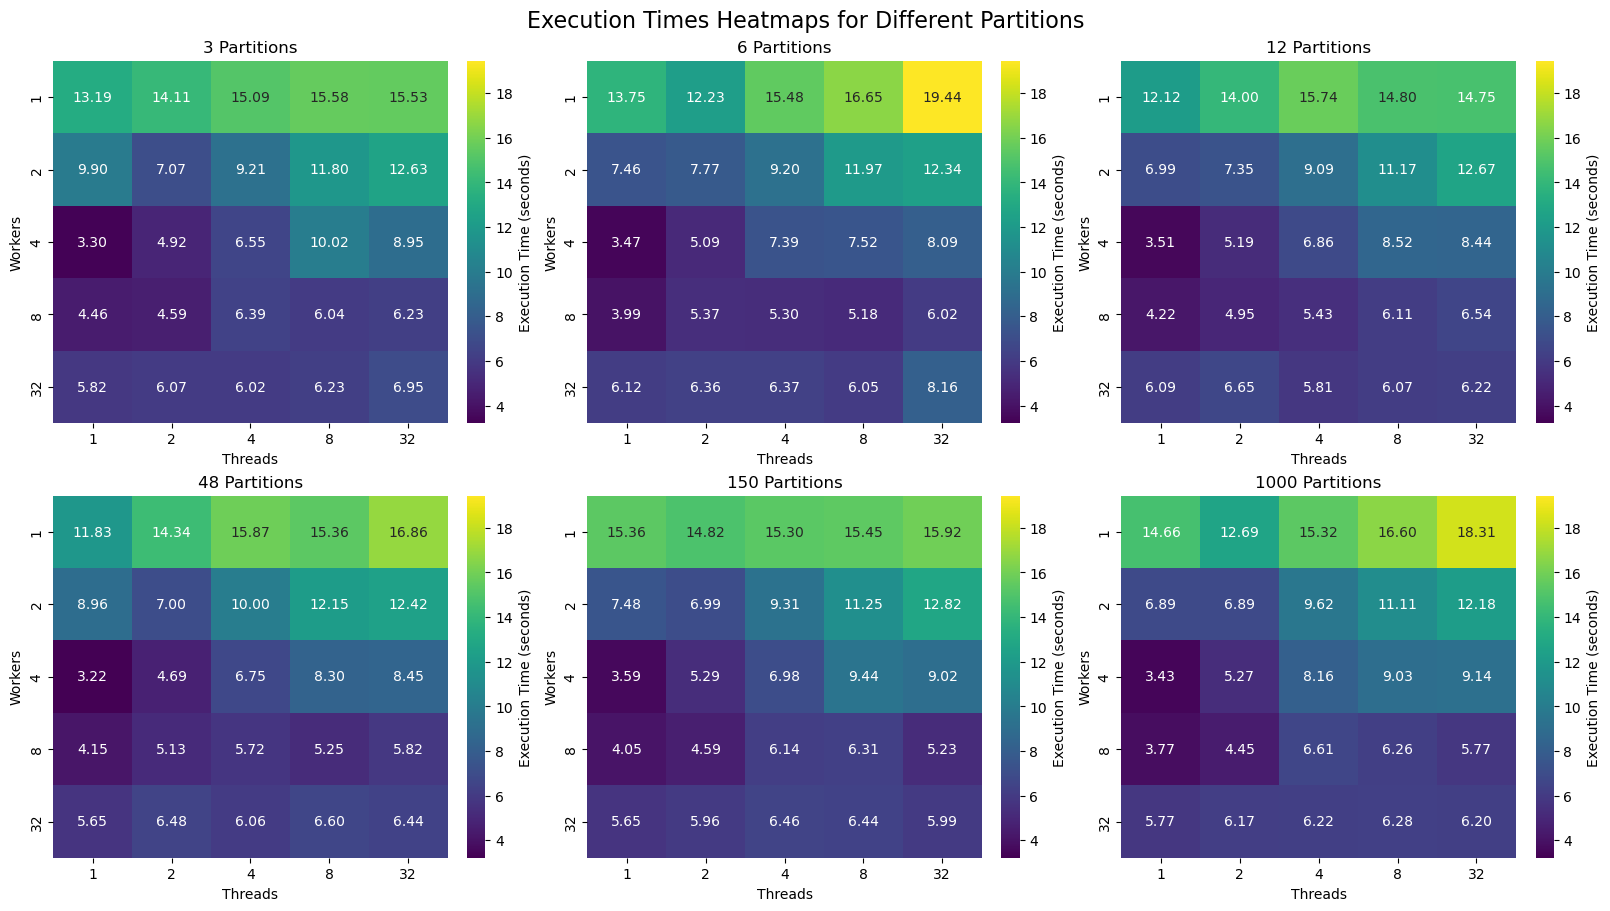

In [70]:
plot_timings_heatmap_for_partitions(partition_list, 'global_tracks')

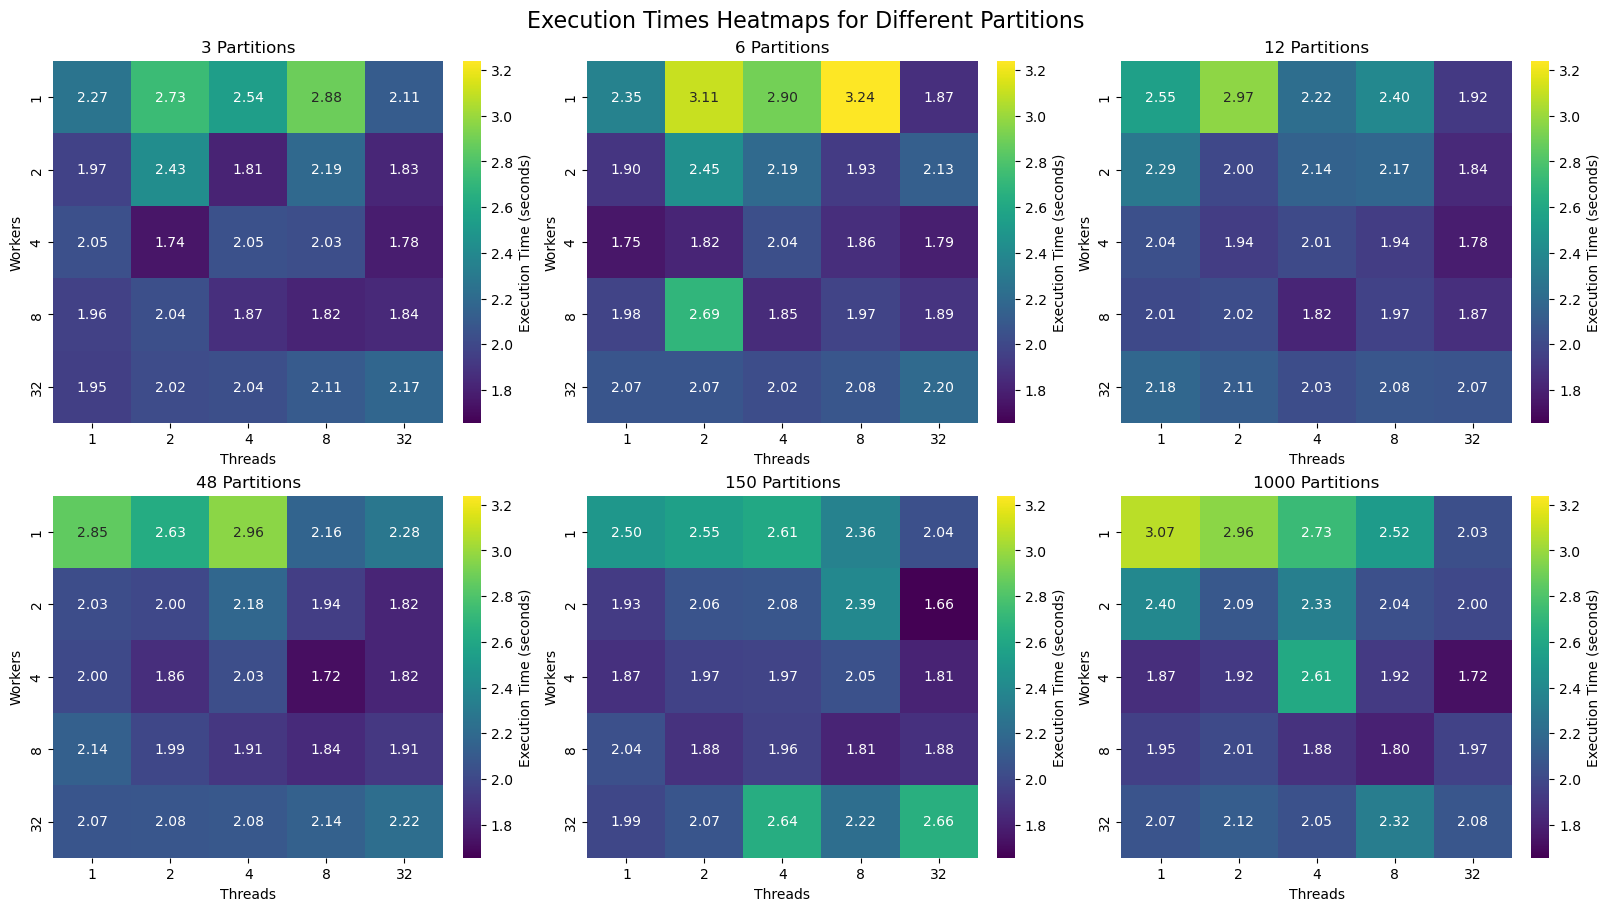

In [71]:
plot_timings_heatmap_for_partitions(partition_list, 'angular_difference')

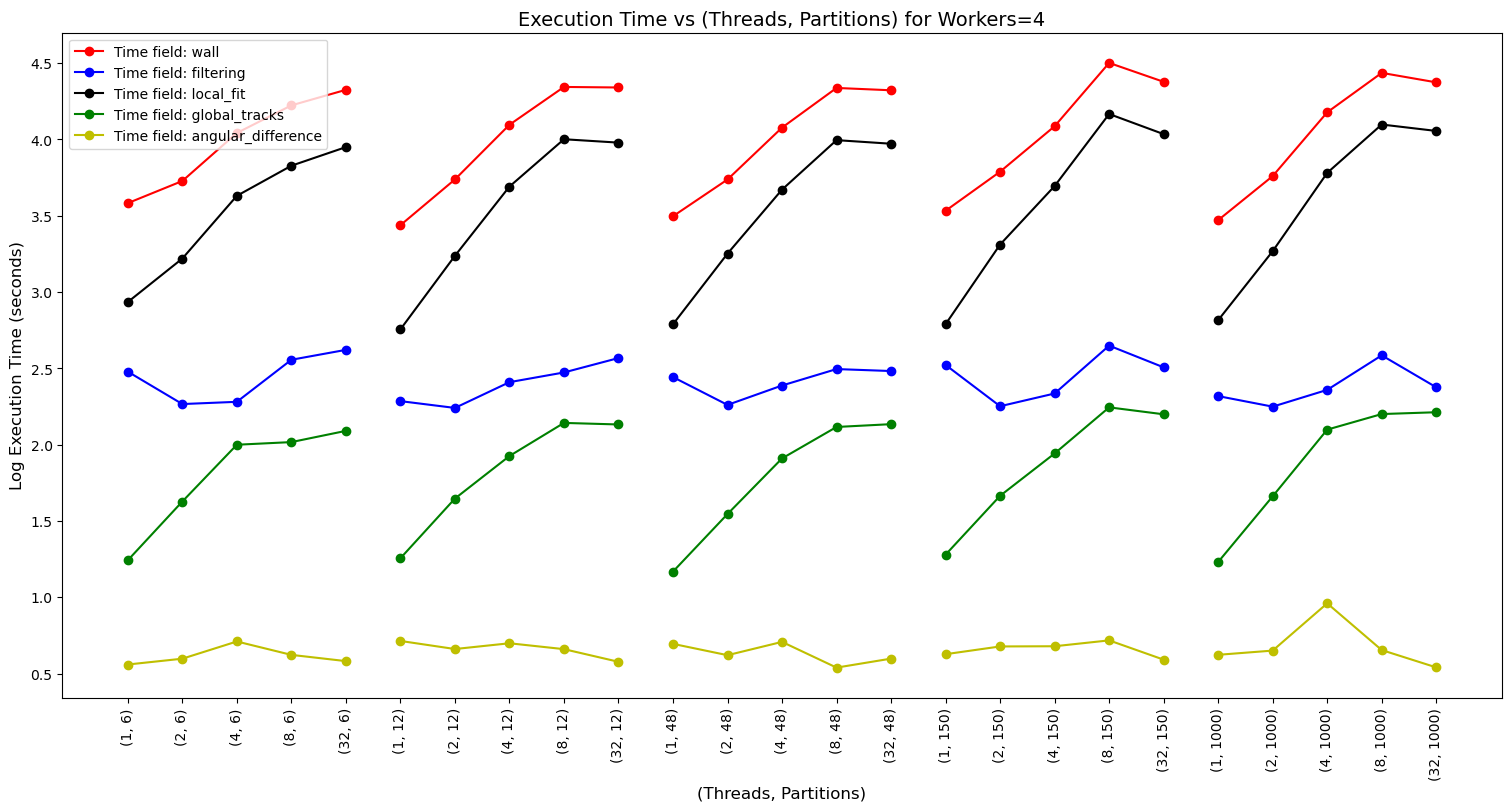

In [72]:
plot_time_chunks([6, 12, 48, 150, 1000])